##### data collected from: https://www.kaggle.com/datasets/rabieelkharoua/predicting-manufacturing-defects-dataset

In [1]:
# set the random seed for reproducibility
import random
random.seed(42)

In [2]:
# import needed libraries and load the dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# load the dataset
manufacturing_defect = pd.read_csv("manufacturing_defect_dataset.csv")

##### Exploratory Data Analysis

In [3]:
# display the first 5 rows of the dataset
manufacturing_defect.head()

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


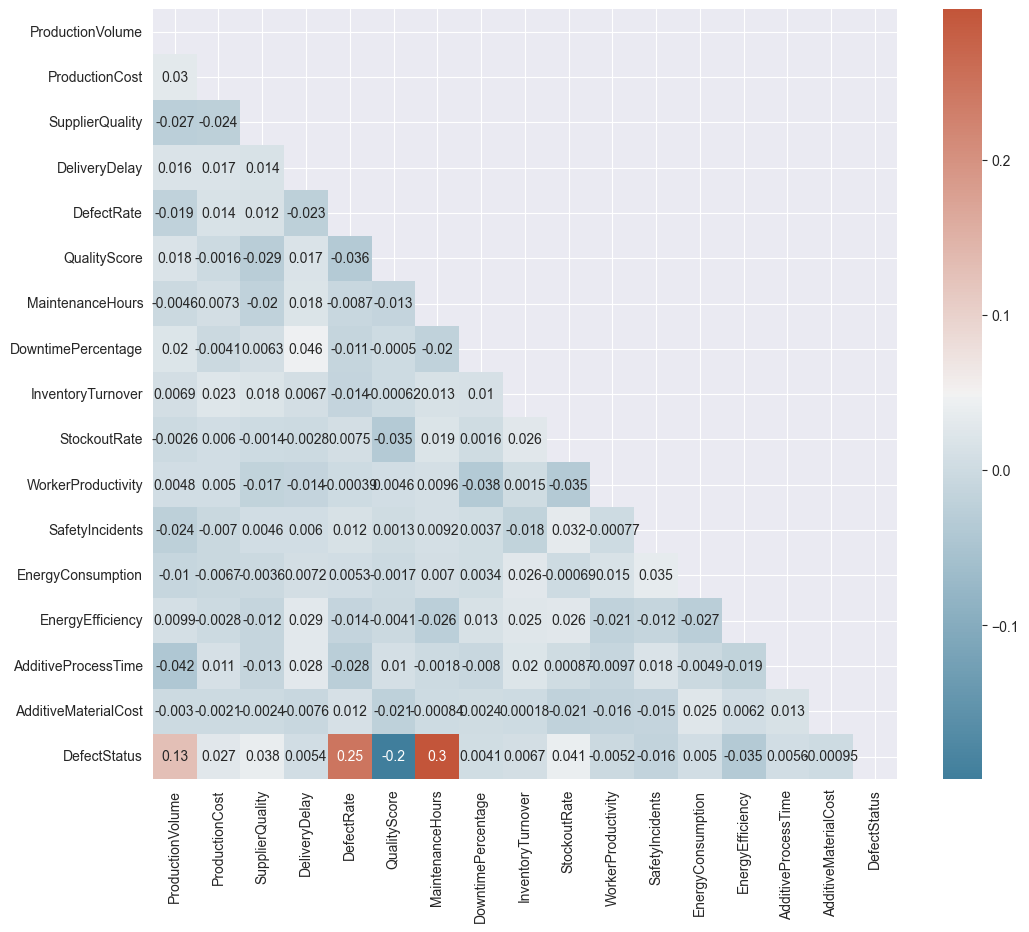

In [4]:
# calculate the correlation matrix of the dataset
corr = manufacturing_defect.corr()
# create a boolean mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.figure(figsize = (12, 10))
# generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap = True)
# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, annot = True)
plt.show()

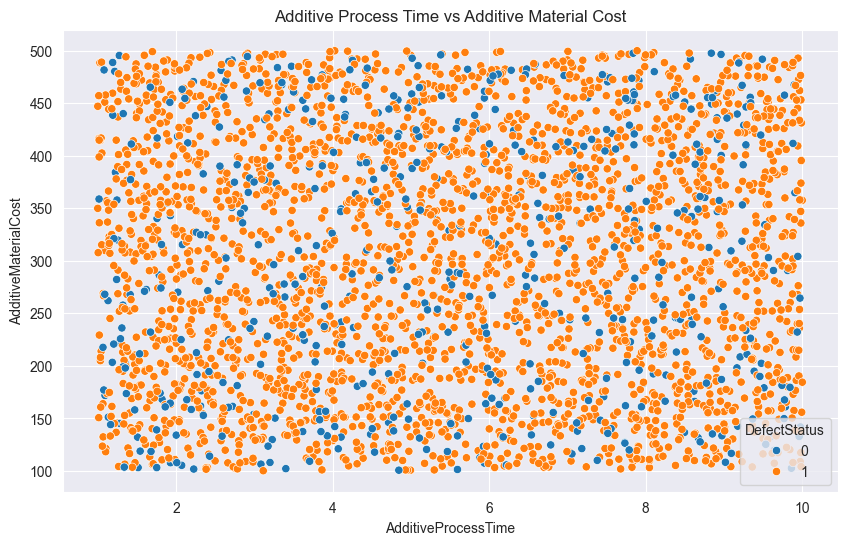

In [5]:
# add comments for the bottom code
plt.figure(figsize = (10, 6))
# different DefectStatus values are represented with different colors
sns.scatterplot(x = "AdditiveProcessTime", y = "AdditiveMaterialCost", hue = "DefectStatus", data = manufacturing_defect)
plt.title("Additive Process Time vs Additive Material Cost")
plt.show()

##### Data Preprocessing

In [6]:
# convert the categorical columns to object type to be able to preprocess them using the pipeline in the further steps
manufacturing_defect["DefectStatus"] = manufacturing_defect["DefectStatus"].astype("object")
manufacturing_defect["DeliveryDelay"] = manufacturing_defect["DeliveryDelay"].astype("object")
manufacturing_defect["MaintenanceHours"] = manufacturing_defect["MaintenanceHours"].astype("object")

# separate the numerical and categorical columns in the dataset to preprocess them separately using the pipeline in the further steps
numerical_cols = manufacturing_defect.select_dtypes(include = ["float64", "int64"]).columns
categorical_cols = manufacturing_defect.select_dtypes(include = ["object"]).columns
# remove the target column from the categorical columns list to avoid preprocessing it with the pipeline in the further steps
categorical_cols = categorical_cols.drop("DefectStatus")

In [7]:
# create a pipeline to preprocess the numerical and categorical columns separately using the ColumnTransformer class
numerical_transformer = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy = "mean")), # impute the missing values with the mean of the column
    ("scaler", MinMaxScaler()) # scale the numerical columns to be in the range [0, 1]
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy = "most_frequent")) # impute the missing values with the most frequent value of the column
])

# combine the numerical and categorical transformers in one preprocessor
preprocessor = ColumnTransformer(transformers = [
    ("num", numerical_transformer, numerical_cols), # apply the numerical transformer on the numerical columns
    ("cat", categorical_transformer, categorical_cols) # apply the categorical transformer on the categorical columns
])

In [8]:
# separate the features and target columns in the dataset to build the model using the features and target columns separately
X = manufacturing_defect.drop("DefectStatus", axis = 1)
y = manufacturing_defect["DefectStatus"]

In [9]:
# encode the target column to be able to build the model using it as the target column
le = LabelEncoder()
y = le.fit_transform(y)

# preprocess the features columns using the preprocessor pipeline created in the previous steps and convert the preprocessed features to a DataFrame
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed = pd.DataFrame(X_preprocessed, columns = [numerical_cols.tolist() + categorical_cols.tolist()])

##### Feature Selection

In [10]:
# select the best 3 features using the chi2 statistical test to build the model using them as the features columns
fs = SelectKBest(score_func=chi2, k = 3)
# fit the feature selector on the preprocessed features and target columns to select the best 3 features using the chi2 statistical test
X_selected = fs.fit_transform(X_preprocessed, y)
# get the selected features names
selected_features = X_preprocessed.columns[fs.get_support()]
# get the selected features columns from the preprocessed features columns to build the model using them as the features columns
X_selected = X_preprocessed[selected_features]

In [11]:
# split the selected features and target columns into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.2, stratify = y, random_state = 42)

##### Model Building

In [12]:
# use the GridSearchCV class to find the best hyperparameters for the RandomForestClassifier model using the selected features and target columns to build the model
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# use the RandomForestClassifier model to build the model
rf = RandomForestClassifier()

# use the GridSearchCV class to find the best hyperparameters for the RandomForestClassifier model using the selected features and target columns to build the model
grid_search = GridSearchCV(rf, param_grid, cv = 5)

# fit the grid search on the training set to find the best hyperparameters for the RandomForestClassifier model
grid_search.fit(X_train, y_train)

# get the best hyperparameters for the RandomForestClassifier model
best_params = grid_search.best_params_

In [13]:
# build the RandomForestClassifier model using the best hyperparameters found in the previous step and the selected features and target columns
rf = RandomForestClassifier(n_estimators = best_params["n_estimators"], max_depth = best_params["max_depth"], min_samples_split = best_params["min_samples_split"], min_samples_leaf = best_params["min_samples_leaf"])
# fit the RandomForestClassifier model on the training set
rf.fit(X_train, y_train)
# predict the target column values using the testing set
y_pred = rf.predict(X_test)

In [14]:
# evaluate the model using the testing set and display the classification report of the model
print("Accuracy of the model: ", rf.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Accuracy of the model:  0.9012345679012346
              precision    recall  f1-score   support

           0       0.69      0.70      0.69       103
           1       0.94      0.94      0.94       545

    accuracy                           0.90       648
   macro avg       0.81      0.82      0.82       648
weighted avg       0.90      0.90      0.90       648



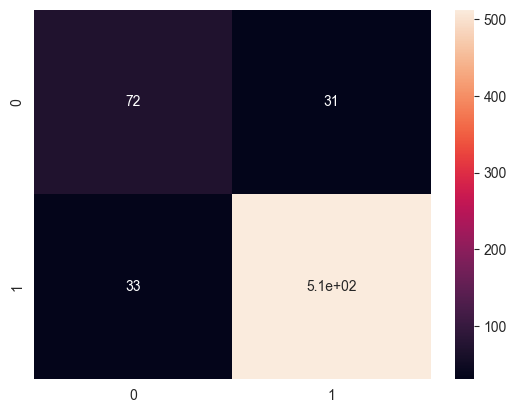

In [15]:
# display the confusion matrix of the model using the testing set
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot = True)
plt.show()

In [ ]:
# use the GradientBoostingClassifier model to build the model
gb = GradientBoostingClassifier()
# use the GridSearchCV class to find the best hyperparameters for the GradientBoostingClassifier model using the selected features and target columns to build the model
grid_search = GridSearchCV(gb, param_grid, cv = 5)
# fit the grid search on the training set to find the best hyperparameters for the GradientBoostingClassifier model
grid_search.fit(X_train, y_train)
# get the best hyperparameters for the GradientBoostingClassifier model
best_params = grid_search.best_params_

In [ ]:
# build the GradientBoostingClassifier model using the best hyperparameters found in the previous step and the selected features and target columns
gb = GradientBoostingClassifier(n_estimators = best_params["n_estimators"], max_depth = best_params["max_depth"], min_samples_split = best_params["min_samples_split"], min_samples_leaf = best_params["min_samples_leaf"])
# fit the GradientBoostingClassifier model on the training set
gb.fit(X_train, y_train)
# predict the target column values using the testing set
y_pred = gb.predict(X_test)

In [ ]:
# evaluate the model using the testing set and display the classification report of the model
print("Accuracy of the model: ", gb.score(X_test, y_test))
print(classification_report(y_test, y_pred))

In [ ]:
# display the confusion matrix of the model using the testing set
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot = True)
plt.show()